In [1]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

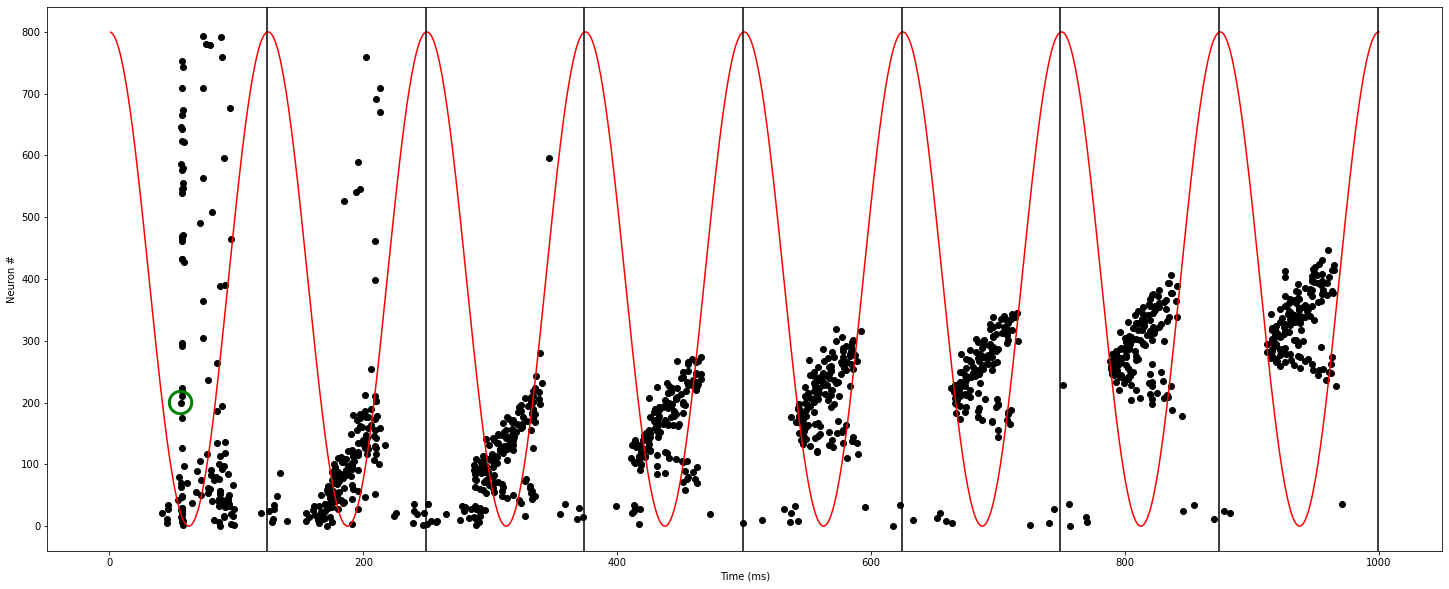

In [2]:
N = 1000; Ne = int( 0.8*N ); Ni = int( 0.2*N );

T = 1; # total time we want to simulate, 4 s
dt = 0.001; # 1 ms temporal resolution

time = np.linspace(dt,T, int(T/dt)) # time in ms

# decide which 20% neurons are inhibitory
inhibitory_indx = np.sort(np.random.choice(range(N),Ni,replace=False))
#inhibitory_indx

J0 = 0.3; J1 = 0.015; J2 = 0.02; l = 0.15
sigma =1.8

x0 =  time/3
I0 = 1.02
lambda_e = 0.03
lambda_i = 0.02
Vres = 0.85
theta = 1

# i-d array, storing the position of each neuron
positions = np.linspace(0,1,N,endpoint=False)
#positions = np.random.uniform(0,1,N)
positions[inhibitory_indx]=0

# pre-define Jij_ex
Jij_ex = np.zeros([N, N])

def s_in():
    rand = np.random.uniform(0,1,1)
    if rand<0.7:
        return 1
    else:
        return 0
    
def s_ex():
    rand = np.random.uniform(0,1,1)
    if rand<0.2:
        return 1
    else:
        return 0

def sigmoid(x):
    z = 1 / (1 + np.exp(-x))
    return z

# Equ. 8
def sigma_ij_comp(i,j,sigma):
    if i<j:
        result = 1
    else:
        result = sigma
    return result

def Jij_ex_comp(i, j):
    sigma_ij = sigma_ij_comp(i,j,sigma)
    result = sigma_ij * J1 * np.exp(-np.abs(positions[i]-positions[j])/l)
    return result

def Jij_in_comp(i, j):
    sigma_ij = sigma_ij_comp(i,j,sigma)
    result = sigma_ij * J2 * np.exp(-np.abs(positions[i]-positions[j])/l)
    return result



# compute each element of Jij_ex, treat Jij_ex as a constant matrix
for ii in range(N):
    for jj in range(N):
        Jij_ex[ii,jj] = Jij_ex_comp(ii,jj)
    
#Jij_ex=np.interp(Jij_ex, (Jij_ex.min(), Jij_ex.max()), (0, 1))
Jij_ex[Jij_ex>=0.011]=1

# compute each element of Jij_in, treat Jij_in as a constant matrix
#Jij_in = np.zeros([N, N])
#for ii in range(N):
#    for jj in range(N):
#        Jij_in[ii,jj] = Jij_in_comp(ii,jj)
Jij_in=np.ones([1000,1000]) 
#Jij_in=np.random.rand(1000,1000)
#Jij_in=np.zeros([n,N])

# Equ. 9
I_ext_ex = np.zeros([Ne, len(time)])

for i in range(Ne):
    for t in range(len(time)):
        I_ext_ex[i,t] = I0 * (1 + lambda_e*np.exp(-np.abs(positions[i]-x0[t])/l))
I_ext_ex=np.interp(I_ext_ex, (I_ext_ex.min(), I_ext_ex.max()), (1, 1.01))

# Equ. 10
I_ext_in = np.zeros(len(time))

for t in range(len(time)):
    I_ext_in[t] = I0 * (1 + lambda_i * np.cos(2*np.pi*time[t]*8)) # 6-9 Hz

I_ext_in


# I_ext = combine I_ext_ex and I_ext_in
I_ext = np.zeros([N, len(time)])
cnt_ex = 0
cnt_in = 0
for i in range(N):
    if i in inhibitory_indx:
        I_ext[i,:] = I_ext_in
        cnt_in = cnt_in + 1
    else:
        I_ext[i,:] = I_ext_ex[cnt_ex,:]
        cnt_ex = cnt_ex + 1
        

def delta_kronecker(delta_t):
    if delta_t == 0:
        return 1
    else:
        return 0

# compute I_ex and I_in
I_ex = np.zeros([N, len(time)])
I_in = np.zeros([N, len(time)])

t_spike = np.zeros([N, len(time)])

Is = I_ex - I_in

V = np.zeros([N, len(time)])
V[:,0] = Vres

tau_ex = 6/1000
tau_in = 4/1000
tau = 20/1000

# Equ. 3
def integrate_and_fire(V, t_spike_time, t, Is):
    for i in range(N):
        I_in[i,t] = I_in[i,t-1] + dt*(-I_in[i,t-1]/tau_in + s_in()*np.dot(Jij_in[i,:],t_spike_time[:,t-1]))
        I_ex[i,t] = I_ex[i,t-1] + dt*(-I_ex[i,t-1]/tau_ex + s_ex()*np.dot(Jij_ex[i,:],t_spike_time[:,t-1]))           
    Is = I_ex - I_in
    dV = dt*(-V[:,t-1] + Is[:,t-1] + I_ext[:,t-1])/tau
    V[:,t] = V[:,t-1] + dV
    for i in range(N):
        if V[i,t]>theta:
            t_spike_time[i,t] = 1
            V[i,t] = Vres
            
    return V, t_spike_time, Is

for t in range(1,len(time)):
    V, t_spike, Is = integrate_and_fire(V, t_spike, t, Is)
    

#t_spike
index=ones([1000],dtype=bool)
index[inhibitory_indx]=0
t_spikep=t_spike[index,:]
t_spikei=t_spike[inhibitory_indx,:]


plt.figure(figsize=(25,10))
plt.plot(time*1000, np.interp(I_ext_in, (I_ext_in.min(), I_ext_in.max()), (0, Ne)),color='red')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron #')
plt.scatter(np.where(t_spikep==1)[1], np.where(t_spikep==1)[0],color='black')
#plotting example neuron 200
ex_neuron=200
t_spikep=t_spikep[ex_neuron,:]
y=ones(size(np.where(t_spikep==1)[0]))*ex_neuron
plt.scatter(np.where(t_spikep==1)[0],y,s=500,color='green',facecolors='none',linewidths=3)
#plt.figure(figsize=(25,10))
#plt.xlabel('Time (ms)')
#plt.ylabel('Neuron #')
#plt.scatter(np.where(t_spikei==1)[1], np.where(t_spikei==1)[0],color='blue')
xc=np.where(I_ext_in==I_ext_in.max())[0]
for i in xc:
    plt.axvline(x=i,color='black')

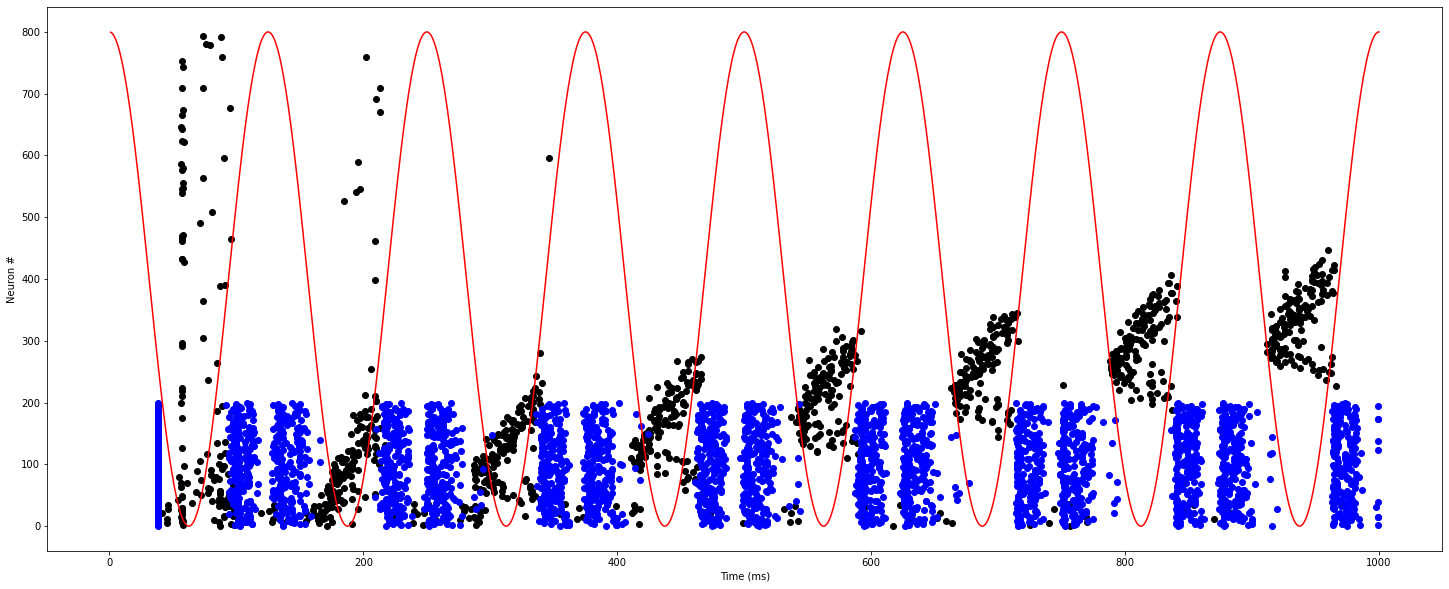

In [3]:
#Jij_ex[Jij_ex>=0.011]=0.025
index=ones([1000],dtype=bool)
index[inhibitory_indx]=0
t_spikep=t_spike[index,:]
t_spikei=t_spike[inhibitory_indx,:]


plt.figure(figsize=(25,10))
plt.plot(time*1000, np.interp(I_ext_in, (I_ext_in.min(), I_ext_in.max()), (0, Ne)),color='red')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron #')
plt.scatter(np.where(t_spikep==1)[1], np.where(t_spikep==1)[0],color='black')
#plt.figure(figsize=(25,10))
plt.xlabel('Time (ms)')
plt.ylabel('Neuron #')
plt.scatter(np.where(t_spikei==1)[1], np.where(t_spikei==1)[0],color='blue')


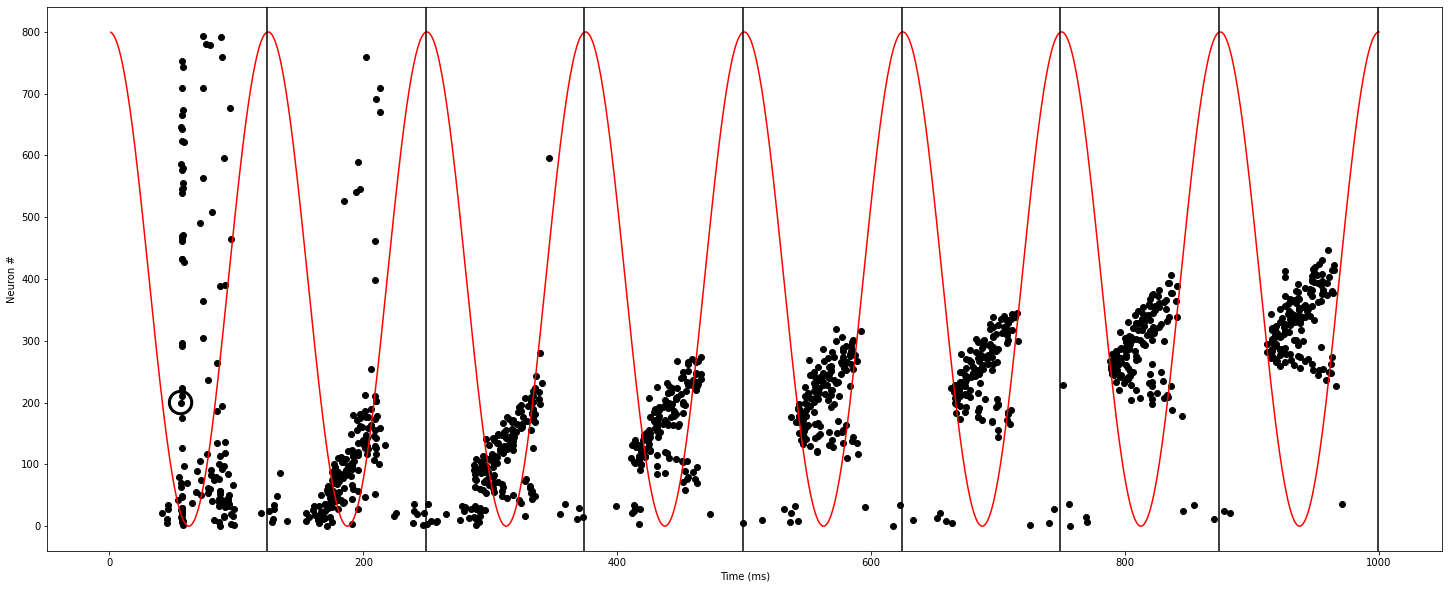

In [4]:
#t_spike
index=ones([1000],dtype=bool)
index[inhibitory_indx]=0
t_spikep=t_spike[index,:]
t_spikei=t_spike[inhibitory_indx,:]


plt.figure(figsize=(25,10))
plt.plot(time*1000, np.interp(I_ext_in, (I_ext_in.min(), I_ext_in.max()), (0, Ne)),color='red')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron #')
plt.scatter(np.where(t_spikep==1)[1], np.where(t_spikep==1)[0],color='black')
#plotting example neuron 200
t_spikep=t_spikep[200,:]
plt.scatter(np.where(t_spikep==1)[0],200,s=500,color='black',facecolors='none',linewidths=3)
#plt.figure(figsize=(25,10))
#plt.xlabel('Time (ms)')
#plt.ylabel('Neuron #')
#plt.scatter(np.where(t_spikei==1)[1], np.where(t_spikei==1)[0],color='blue')
xc=np.where(I_ext_in==I_ext_in.max())[0]
for i in xc:
    plt.axvline(x=i,color='black')
   

In [5]:
N = 100
J0 = 0.3; J1 = 0.4; l = 0.2
Jij = np.zeros([N,N])

positions = np.random.uniform(0,1,N)

for i in range(N):
    for j in range(N):
        Jij[i,j] = J1 * np.exp(-np.abs(positions[i]-positions[j])/l) - J0

In [6]:
dt = 0.001; T = 1
time = np.linspace(dt,T,int(T/dt))
r = np.zeros([N, len(time)])
V = np.zeros([N, len(time)])
spikes = np.zeros([N, len(time)])
tau = 20/1000

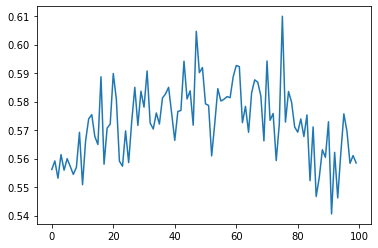

In [7]:
Ie_l = np.linspace(0,0.5,50) * 0.06 + 0.55 + np.random.randn(50) * 0.01 + 0.01
Ie_r = np.linspace(0.5,1,50) * (-0.06) + 0.61 + np.random.randn(50) * 0.01 + 0.01
Ie = numpy.concatenate([Ie_l,Ie_r])
plt.plot(Ie)

In [ ]:
plot(Jij_ex[300,:])